In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import scikitplot as skplt # pip install scikit-plot

#### Q1.

Exploratory analysis of the dataset.

In [2]:
pd.set_option("display.max_columns", None)

df = pd.read_csv("European_bank_marketing.csv")
df.drop(columns='duration', inplace=True) # Drop duration as mentioned in footnotes of assignment outline

df.iloc[np.random.randint(0, len(df), size=20)] # Get 20 random observations from sample

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,term_deposit,Ethnicity_African
25219,41,technician,married,basic.9y,no,yes,no,telephone,nov,tue,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,0,0
31668,57,retired,married,basic.6y,no,no,yes,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,0,0
32001,49,blue-collar,married,basic.9y,no,no,no,cellular,may,thu,2,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,0,0
11932,32,services,married,high.school,no,no,no,telephone,jun,fri,4,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,0
30173,53,management,divorced,university.degree,no,no,no,cellular,apr,thu,1,999,0,nonexistent,-1.8,93.075,-47.1,1.365,5099.1,0,0
11085,40,admin.,single,university.degree,no,no,no,telephone,jun,thu,2,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0,0
20916,30,admin.,single,university.degree,no,yes,no,cellular,aug,thu,1,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0,0
16072,35,services,single,high.school,unknown,yes,no,cellular,jul,tue,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0,0
28122,41,unemployed,married,basic.9y,no,no,yes,cellular,apr,mon,1,9,1,success,-1.8,93.075,-47.1,1.466,5099.1,0,0
25835,32,entrepreneur,married,basic.4y,no,yes,no,cellular,nov,wed,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0,0


Look at counts for each category in our categorical variables.

In [3]:
for (column_name, column_data) in df.iteritems():
    if column_data.dtype == 'object':
        print(f"{column_name}\n{df[column_name].value_counts().to_string()}\n")

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330

marital
married     24928
single      11568
divorced     4612
unknown        80

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18

default
no         32588
unknown     8597
yes            3

housing
yes        21576
no         18622
unknown      990

loan
no         33950
yes         6248
unknown      990

contact
cellular     26144
telephone    15044

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182

day_of_week
thu    8623
mon    851

Bar plot showing the frequency of observations in the variable of interest 'term_deposit'.

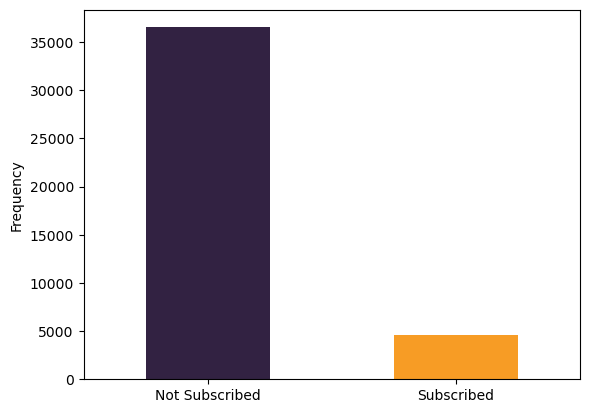

In [4]:
colors = ['#322242', '#f79c25']
ax = df['term_deposit'].value_counts().plot(kind='bar', color=colors)
ax.set_xticklabels(labels=['Not Subscribed', 'Subscribed'], rotation='horizontal')
ax.set_ylabel("Frequency")
plt.show()

Correlation heatmap between each of the numerical variables in our dataset with the variable of interest.

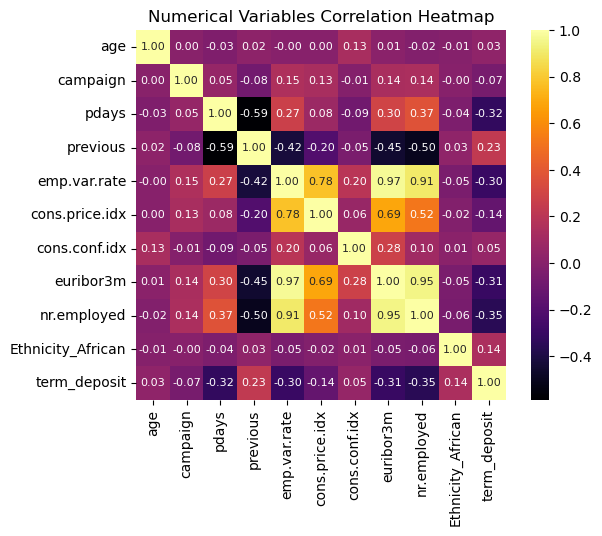

In [5]:
numer_vars = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 
              'cons.conf.idx', 'euribor3m', 'nr.employed', 'Ethnicity_African', 'term_deposit']

corr_matrix = df[numer_vars].corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols, cmap='inferno')
hm.set_title("Numerical Variables Correlation Heatmap")
plt.show()

Relatively low correlation between between our predictor variables, with only. We see that the variables most highly correlated with the variable of interest 'term_deposit' are: 
* pdays
* emp.var.rate
* euribor3m 
* nr.employed 

Calculation of principal components, with plot of the cumulative proportion of variance explained by each Principal Component.

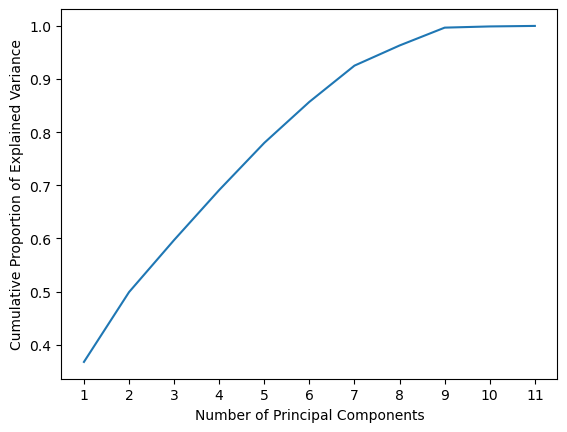

In [6]:
predictors = [column for column in df.columns if column != 'term_deposit']

df_train = pd.get_dummies(df[numer_vars])
SS = StandardScaler()
scaler = SS.fit(df_train)
df_scaled = scaler.transform(df_train)
df_scaled = pd.DataFrame(df_scaled, columns=df_train.columns)
covar = df_scaled.cov()

u, s, vh = np.linalg.svd(covar)
explained_var = np.zeros(len(s))
for i in range(len(s)):
    explained_var[i] = s[i]/len(s)

fig, ax = plt.subplots()
plt.plot(np.cumsum(explained_var))
ax.set_xticks(range(0,len(s)), labels=range(1,len(s)+1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Proportion of Explained Variance")
plt.show()

As we might have expected from the low correlations seen in the heatmap, not a lot of the variance in the predictor variables is explained by the first few principal components.

Look at the first 4 Principal Components to see which variables they are loaded on.

In [7]:
pd.DataFrame(u[0:4].T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_train.columns)
# Need to check whether this is correct***

,PC1,PC2,PC3,PC4
age,0.004115,-0.097432,-0.235263,0.302329
campaign,-0.212939,-0.014822,0.567515,-0.378643
pdays,0.658966,-0.301391,0.219724,-0.241728
previous,-0.067069,-0.033630,0.215591,-0.272041
emp.var.rate,-0.436210,-0.884980,-0.045569,0.015653
cons.price.idx,0.565534,-0.338750,-0.032113,0.168976
cons.conf.idx,0.067018,-0.009655,0.135800,-0.307371
euribor3m,0.034422,-0.001662,-0.372953,-0.037322
nr.employed,0.010734,-0.013960,-0.605943,-0.712583
Ethnicity_African,-0.001851,-0.000149,-0.002946,0.018069


#### Q2 a)

Fit a logistic regression model on the full set (may want to narrow down) of data.

Create confusion matrices for probability thresholds of 0.1, 0.2, 0.35 & 0.5.

In [8]:
df_train_X = df[predictors]
df_train_Y = df['term_deposit']
df_train_X = pd.get_dummies(df_train_X, drop_first=True)

logreg = LogisticRegression(max_iter=1000)
model=logreg.fit(df_train_X, df_train_Y)

# print(f'Number of iterations before convergence: {model.n_iter_[0]}')
col_names = np.insert(model.feature_names_in_, 0, 'Intercept')
model_coef = np.concatenate(([model.intercept_], model.coef_), axis=1)
pd.DataFrame(model_coef, index=['Beta'], columns=col_names)

,Intercept,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Ethnicity_African,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
Beta,0.002569,0.004462,-0.04423,-0.001933,-0.297882,-0.21199,0.326265,0.013463,-0.123675,-0.005816,0.445434,-0.193238,-0.015817,-0.012469,-0.013606,0.103353,-0.001614,-0.07511,0.077545,0.023872,0.003579,-0.005889,-0.074458,0.113744,0.003241,-0.016088,-0.104065,-0.033314,0.003321,0.0129,0.153296,0.03025,-0.202745,-0.000285,-0.008089,-0.015662,-0.008089,-0.018179,-0.391619,0.0824,0.026732,0.268467,0.092431,0.204846,-0.709383,-0.069157,0.02677,-0.022959,-0.18619,0.073411,0.043513,0.102871,0.266025,0.037934


In [9]:
prob_est = model.predict_proba(df_train_X)[:,1]
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.1, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.075362       0.170317
          Not Subscribed   0.037292       0.717029

In [10]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.2, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.063951       0.085923
          Not Subscribed   0.048704       0.801423

In [11]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.35, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.041371       0.037487
          Not Subscribed   0.071283       0.849859

In [12]:
df_pred = pd.concat([pd.Series(np.zeros(len(df_train_Y), dtype=int), name='classification'), df_train_Y], axis=1)
df_pred.loc[prob_est>0.5, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred['term_deposit'], df_pred['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.025639       0.012601
          Not Subscribed   0.087016       0.874745

#### Q2 b)

Fit logistic regression model using a train/test split of 0.7/0.3.

Complete the same steps as above.

In [13]:
df_train_X, df_test_X, df_train_Y, df_test_Y = train_test_split(
    df[predictors], df['term_deposit'], test_size=0.3, random_state=15)

df_train_X = pd.get_dummies(df_train_X, drop_first=True)

logreg = LogisticRegression(max_iter=1000)
model=logreg.fit(df_train_X, df_train_Y)

# print(f'Number of iterations before convergence: {model.n_iter_[0]}')
col_names = np.insert(model.feature_names_in_, 0, 'Intercept')
model_coef = np.concatenate(([model.intercept_], model.coef_), axis=1)
pd.DataFrame(model_coef, index=['Beta'], columns=col_names)

,Intercept,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,Ethnicity_African,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
Beta,0.002484,0.00317,-0.038723,-0.002044,-0.320107,-0.23464,0.307647,0.013895,-0.112719,-0.005448,0.493041,-0.16872,-0.011378,-0.006157,-0.016282,0.096927,-0.006982,-0.073162,0.062092,0.013331,0.000119,-0.003452,-0.088258,0.096643,0.004849,-0.029956,-0.09815,-0.061025,0.003733,0.01184,0.138121,0.053153,-0.186782,-0.000289,-0.011834,-0.04807,-0.011834,0.013539,-0.385039,0.046686,0.031197,0.26381,0.092585,0.221674,-0.721402,-0.072962,0.0413,-0.018201,-0.214265,0.088252,0.044006,0.129344,0.281127,0.040767


In [14]:
df_test_X = pd.get_dummies(df_test_X, drop_first=True)

prob_est = model.predict_proba(df_test_X)[:,1]
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.1, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.076718       0.177227
          Not Subscribed   0.035931       0.710124

In [15]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.2, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.065388       0.089747
          Not Subscribed   0.047261       0.797605

In [16]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.35, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.042891       0.038359
          Not Subscribed   0.069758       0.848992

In [17]:
df_pred_test = pd.concat([pd.Series(np.zeros(len(df_test_Y), dtype=int), name='classification'), df_test_Y.reset_index(drop=True)], axis=1)
df_pred_test.loc[prob_est>0.5, 'classification'] = 1

confusion = pd.DataFrame(np.rot90(confusion_matrix(
    df_pred_test['term_deposit'], df_pred_test['classification'], normalize='all'), 2).T)
confusion.columns = pd.MultiIndex.from_tuples([('Actual', 'Subscribed'), ('Actual', 'Not Subscribed')])
confusion.index = pd.MultiIndex.from_tuples([('Predicted', 'Subscribed'), ('Predicted', 'Not Subscribed')])
confusion

Actual               
                         Subscribed Not Subscribed
Predicted Subscribed       0.025249       0.013596
          Not Subscribed   0.087400       0.873756

#### Q2 c)

Plotting ROC Curve for logistic regression model.

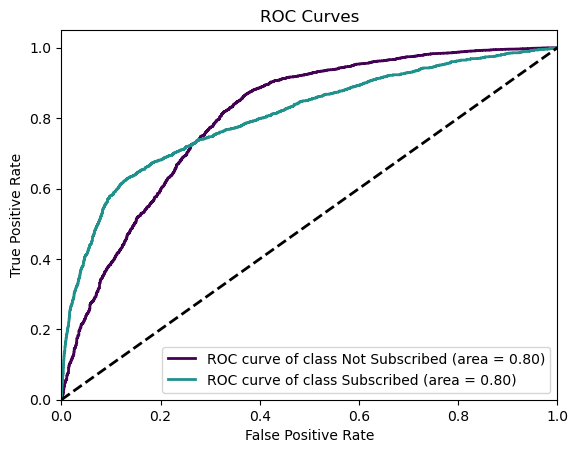

<Figure size 800x800 with 0 Axes>

In [45]:
probas_est = model.predict_proba(df_test_X)

labels = df_test_Y.copy()
labels.loc[labels==0] = 'Not Subscribed'
labels.loc[labels==1] = 'Subscribed'

skplt.metrics.plot_roc(labels, probas_est, plot_micro=False, plot_macro=False, cmap='viridis')
plt.show()